In [1]:
from datetime import date
from qutip import *
from numpy import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
def plot_wigner(rho, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax=plt.subplots(1,1,figsize=(8,8))
    if isket(rho):
        rho=ket2dm(rho)
    xvec=linspace(-7.5, 7.5, 200)
    W=wigner(rho,xvec,xvec)
    wlim=abs(W).max()
    ax.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=mpl.cm.get_cmap('Greys'))
    ax.set_xlabel(r'x1', fontsize=16)
    ax.set_ylabel(r'x2', fontsize=16)
    return fig, ax

In [3]:
class system:
    def __init__(self, catsize, start, stop, num):
        self.catsize=catsize
        self.start=start
        self.stop=stop
        self.num=num
        self.tlist=linspace(self.start, self.stop, self.num)
        self.N=15
        self.x=[]
        self.y=[]
        self.z=[]
        self.fid=[]
        self.t=[]
        self.a=destroy(self.N)
        self.ad=self.a.dag()
        self.H0=self.ad*self.ad*self.a*self.a
        self.Hdet=self.ad*self.a
        self.Hx=self.ad*self.ad+self.a*self.a
        self.Hy=self.ad*self.ad-self.a*self.a
        self.zero=basis(self.N, 0)
        self.one=basis(self.N, 1)
        self.N_plus=(1/(sqrt(2*(1+(exp((-2)*self.catsize))))))
        self.zero=coherent(self.N, 0)
        self.expectedcat=self.N_plus*(coherent(self.N, sqrt(self.catsize))+coherent(self.N, -sqrt(self.catsize)))
    def Epy(self, t,args):
        Ep= self.P0*self.chi*(1-exp((-(t)**4)/(self.tau**4)))
        alpha_0=sqrt(Ep/self.chi)
        alpha_prime=sqrt(0.5*(1/sqrt(self.catsize*(1-exp((-(t)**4)/(self.tau**4)))))*((-1)*self.catsize*exp((-(t)**4)/(self.tau**4)))*((-4)*(t**3)/(self.tau**4)))
        N_m=1/(sqrt(2*(1-exp((-2)*(self.catsize)))))
        return (1j*alpha_prime)/((1+2*alpha_0)*(N_m))
    def init_fidelity_exp(self, spec, kstart, kstop, knum, vstart, vstop, vnum): 
        kerr=linspace(kstart, kstop, knum)
        tau_speed=linspace(vstart,vstop, vnum) # adiabatic cond tau>>1/(Delta_gap=4Kn) =>min v=0.1!(JW setting)
        #power=linspace(self.catsize-1, 4*(self.catsize-1.5), 5 )
        power=linspace(0.5*self.catsize, self.catsize, 5 )
        #power=[4,5]
        for chi in kerr:
            for v in tau_speed:
                for p in power :
                    def Epx_k_v(t, args):
                        return (2*pi)*chi*p*(1-exp((-(t)**4)/((v/(2*pi)*chi)**4)))
                    result=mesolve([(-1)*(2*pi)*chi*self.H0,[self.Hx, Epx_k_v]],self.zero, self.tlist, [], [])
                    # def Epy(t,args):
                    #     Ep= (2*pi)*chi*p*(1-exp((-(t)**4)/((v/(2*pi*chi))**4)))
                    #     alpha_0=sqrt(Ep/(2*pi)*chi)
                    #     alpha_prime=sqrt(0.5*(1/sqrt(self.catsize*(1-exp((-(t)**4)/((v/(2*pi*chi))**4)))))*((-1)*self.catsize*exp((-(t)**4)/((v/(2*pi*chi))**4)))*((-4)*(t**3)/((v/(2*pi*chi))**4)))
                    #     N_m=1/(sqrt(2*(1-exp((-2)*(self.catsize)))))
                    #     return (1j*alpha_prime)/((1+2*alpha_0)*(N_m))
                    # result=mesolve([(-1)*(2*pi)*chi*self.H0,[self.Hx, Epx_k_v],[self.Hy,Epy] ],self.zero, self.tlist, [], [])         
                    # def detuning(t, args):
                    #     return (-1.7)*(2*pi*chi)*(1-(t/(v/(2*pi*chi))))
                    f=[]
                    for i in range(len(self.tlist)):
                        f.append(fidelity(self.expectedcat, result.states[i]))
                    maxfid=max(f)
                    if maxfid<0.9 or maxfid>1.00: #fidelity can be over 100 (ex 124) for extraordinarily distorted cat. need to be excluded!!
                        pass
                    if 0.9<=maxfid<=1.00:
                        self.x.append(chi)
                        self.y.append(v)
                        self.z.append(p)
                        self.fid.append(round(maxfid*100,2))
                        self.t.append(round(((self.stop-self.start)/self.num)*(f.index(maxfid)+1),2))
                    f.clear()
        fig=plt.figure(figsize=(10,10))
        ax=fig.add_subplot(111,projection='3d')
        scatter=ax.scatter(self.x,self.y,self.z, c=self.fid, marker='o', s=15, cmap='Greys',vmin=90,vmax=100)
        ax.set_title(f"catsize={self.catsize}",fontsize=20)
        ax.set_xlabel('kerr(MHz)')
        ax.set_ylabel('ramp speed')
        ax.set_zlabel('MaxDrvAmp')
        plt.colorbar(scatter,shrink=0.6, location='left').set_label('Fidelity(%)')
        name=f"{spec},n={self.catsize},k=({kstart},{kstop},{knum}),v=({vstart},{vstop},{vnum})"
        file_name=f"C:/Users/kimje/Desktop/Project/Posco/Cat/data/fidelity/230219/{name}.png"
        plt.savefig(file_name, format='png', dpi=100, bbox_inches='tight')
        plt.show()
    def generate(self, spec, chi, v, p,speed):
        n=len(self.tlist)
        chi2pi=chi*2*pi
        def E_px(t, args):
            return p*chi2pi*(1-exp((-(t)**4)/((v/chi2pi)**4)))
        H=[(-1)*chi2pi*self.H0,[self.Hx, E_px]]
        result=mesolve(H, self.zero, self.tlist, [], [])        
        # fidelity, time
        f=[]
        for i in range(n):
            f.append(fidelity(self.expectedcat, result.states[i]))
        maxfid=max(f)
        maxfid_idx=f.index(maxfid)
        time_taken=((self.stop-self.start)/self.num)*(maxfid_idx+1)
        print(maxfid)
        print(time_taken)
        # animation
        fig, ax= plt.subplots(1,1,figsize=(8,8))
        def update(frame):
            plot_wigner(result.states[frame*speed], fig=fig, ax=ax)
        ani=animation.FuncAnimation(fig, update, frames=int(n/speed))
        FFwriter=animation.FFMpegWriter()
        name=f"n={self.catsize},{spec},({chi},{v},{p}),Ft=({round(maxfid*100,2)},{round(time_taken,3)}us),t=({self.start},{self.stop},{self.num}).mp4"
        file_name=f"C:/Users/kimje/Desktop/Project/Posco/Cat/animation/230219/{name}.mp4"
        ani.save(file_name, writer=FFwriter)
        plt.close()
        return plot_wigner(result.states[maxfid_idx])
    
        

### init_fidelity only detuning not working -> abandon det, only optimizing drive pump

In [4]:
ref4=system(catsize=4, start=0, stop=2,num=2000)

In [24]:
ref2=system(catsize=2, start=0, stop=2,num=2000)

In [7]:
ref6=system(catsize=6, start=0, stop=2,num=2000)

In [4]:
ref8=system(catsize=8, start=0, stop=2,num=2000)

In [7]:
ref1=system(catsize=10, start=0, stop=2,num=2000)

0.9997564218950233
1.3800000000000001


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

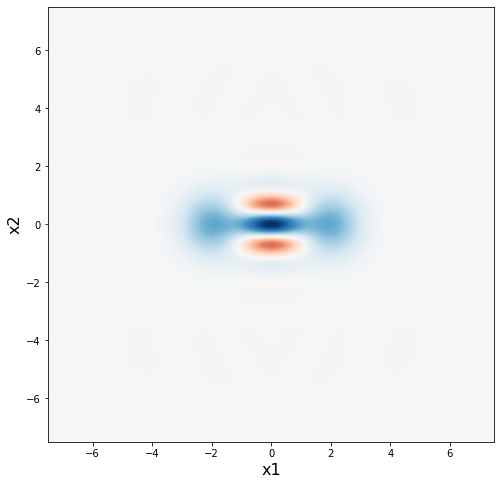

In [49]:
ref2.generate('rdbu',chi=0.75, v=5, p=2, speed=20)

0.998500370278381
1.3800000000000001


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

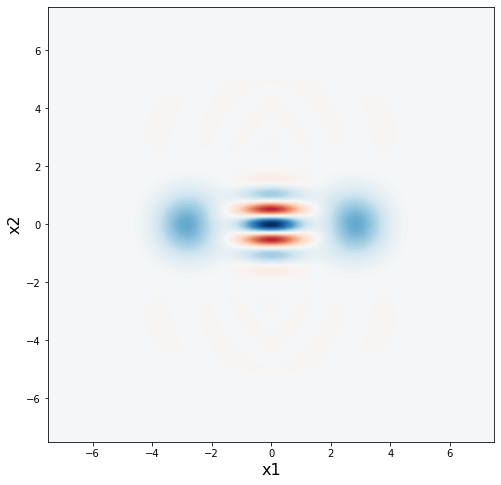

In [50]:
ref4.generate('rdbu',chi=0.75, v=5, p=4, speed=20)

1.0039639756514565
1.348


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

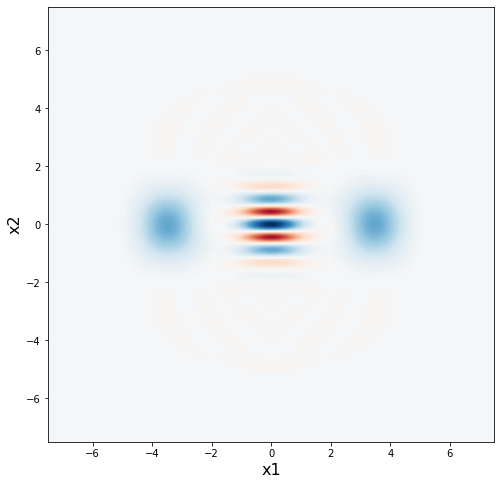

In [51]:
ref6.generate('rdbu',chi=0.75, v=5, p=6, speed=20)

1.0096370843584301
1.96


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

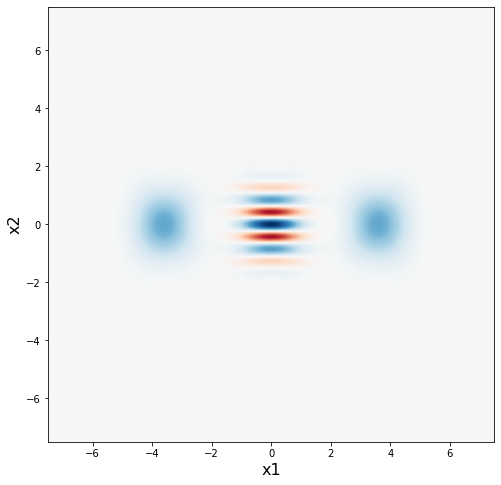

In [57]:
ref8.generate('rdbu',chi=0.75, v=5, p=6, speed=20)

0.991792271291233
1.96


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

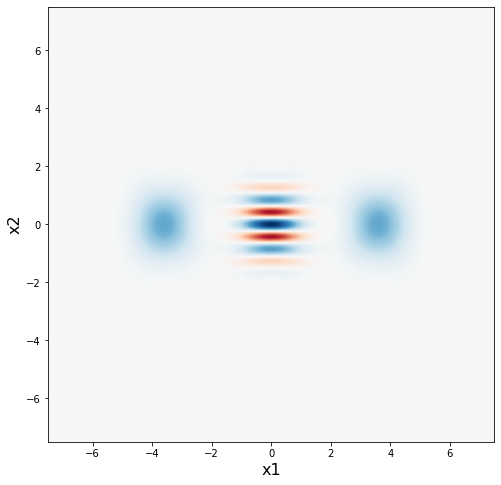

In [55]:
ref1.generate('rdbu',chi=0.75, v=5, p=6, speed=20)

0.9997564218950233
1.3800000000000001


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

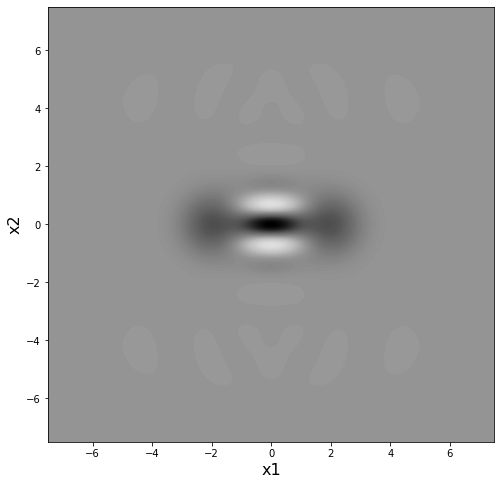

In [ ]:
ref.generate('grey',chi=0.75, v=5, p=4, speed=20)

0.998500370278381
1.3800000000000001


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

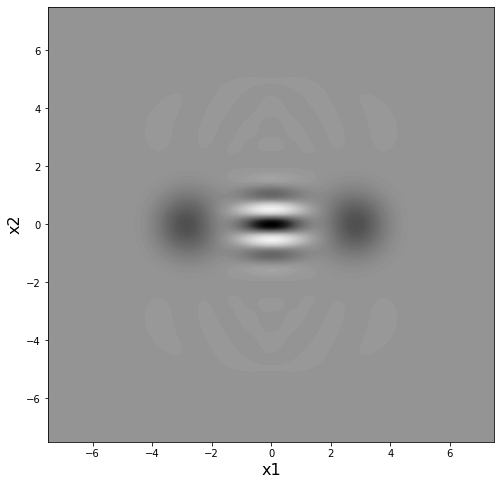

In [ ]:
ref.generate('grey',chi=0.75, v=5, p=4, speed=20)

1.0039639756514565
1.348


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

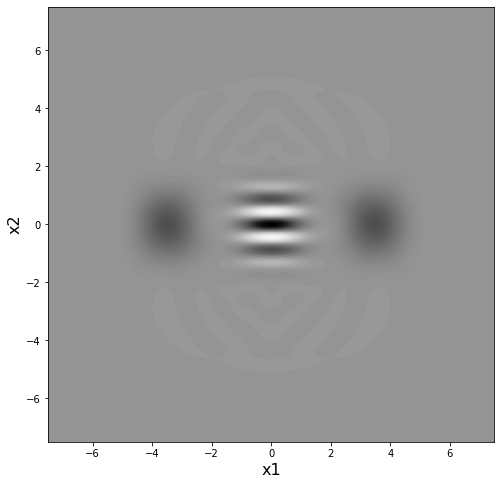

In [35]:
ref.generate('grey',chi=0.75, v=5, p=6, speed=20)

1.0096370843584301
1.96


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

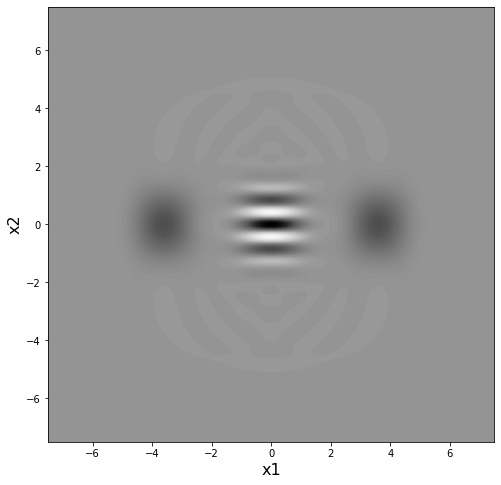

In [17]:
ref8.generate('grey',chi=0.75, v=5, p=6, speed=20)

0.991792271291233
1.96


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:xlabel='x1', ylabel='x2'>)

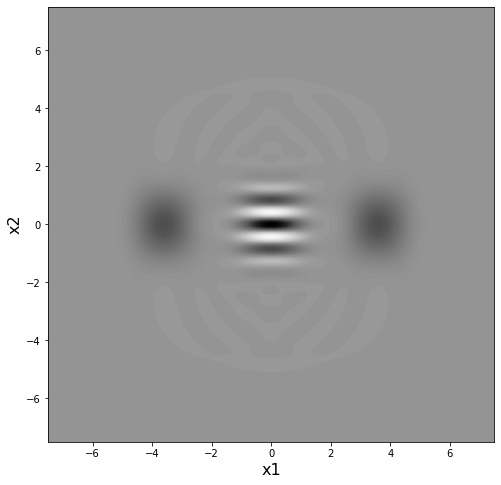

In [23]:
ref1.generate('grey',chi=0.75, v=5, p=6, speed=20)

In [17]:
ref_10=system(catsize=10, start=0, stop=2,num=2000)

In [75]:
ref0=system(catsize=2, start=0, stop=2,num=2000)

In [71]:
ref2=system(catsize=6, start=0, stop=2,num=2000)

In [73]:
ref3=system(catsize=8, start=0, stop=2,num=2000)

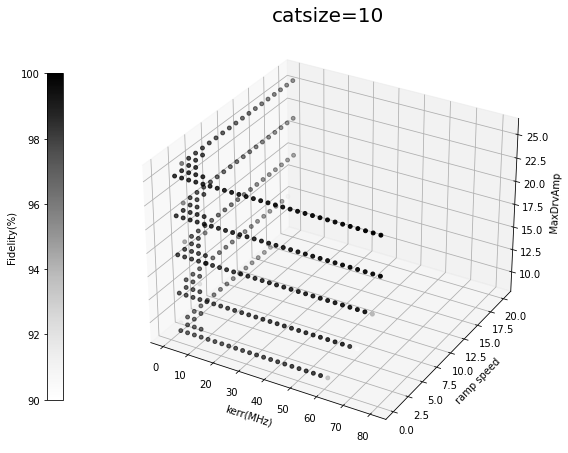

In [18]:
ref_10.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# 3h 

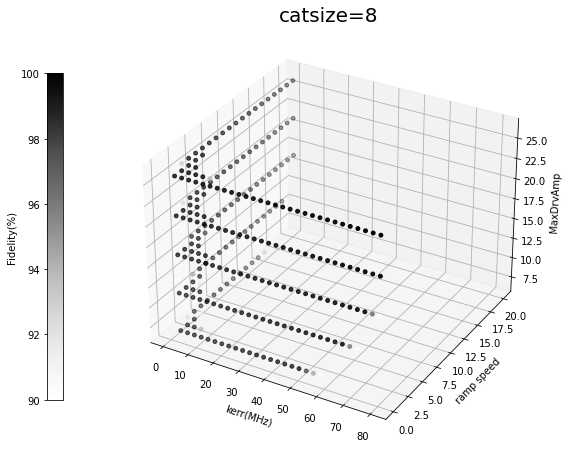

In [74]:
ref3.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# 3h 

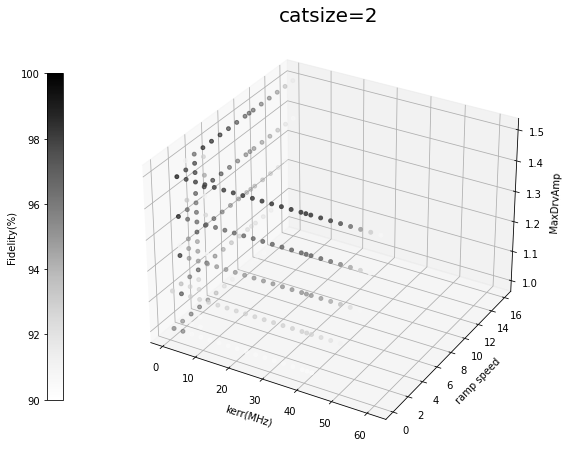

In [26]:
ref2.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# fid<1.00 reflected

In [8]:
ref4.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# fid<1.00 reflected

KeyboardInterrupt: 

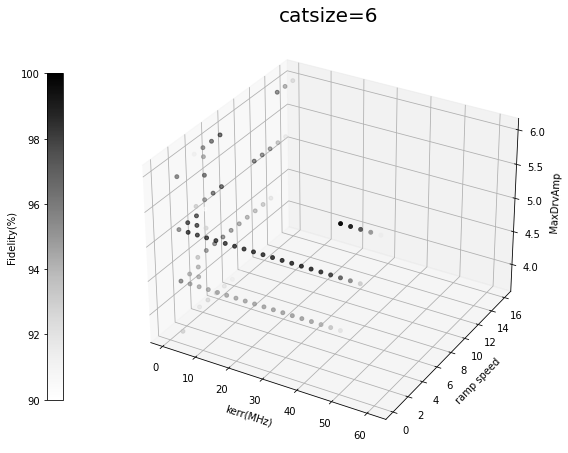

In [8]:
ref6.init_fidelity_exp(spec='p_range',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# fid<1.00 reflected

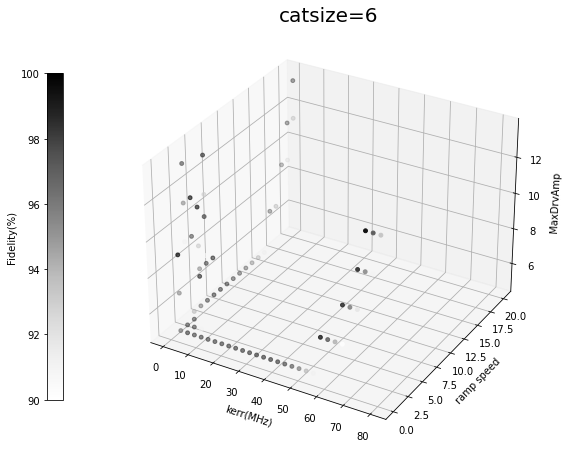

In [ ]:
ref6.init_fidelity_exp(spec='p_range',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# fid<1.00 reflected

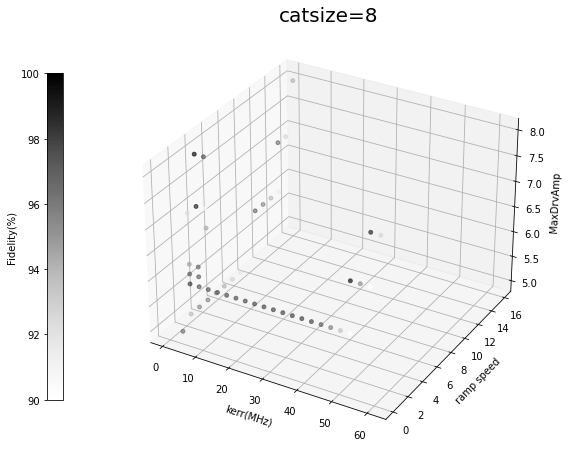

In [5]:
ref8.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# fid<1.00 reflected #p range changed

In [ ]:
ref1.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# fid<1.00 reflected

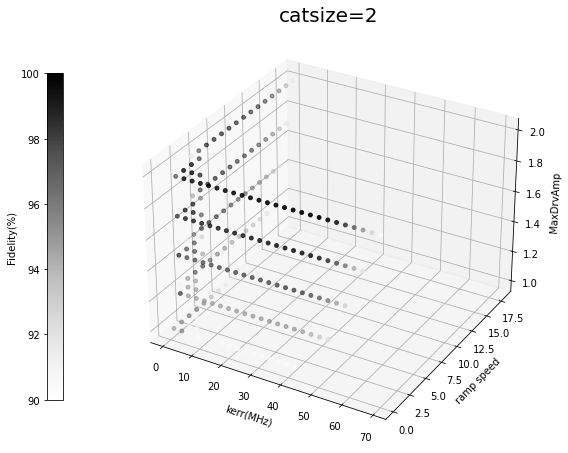

In [ ]:
ref0.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# 3h 

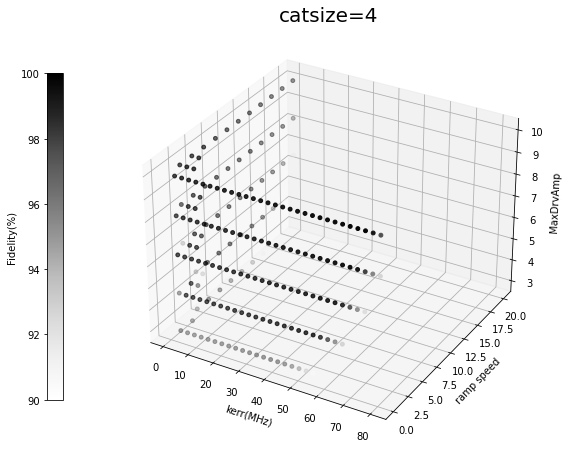

In [ ]:
ref.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=12)
# 3h 

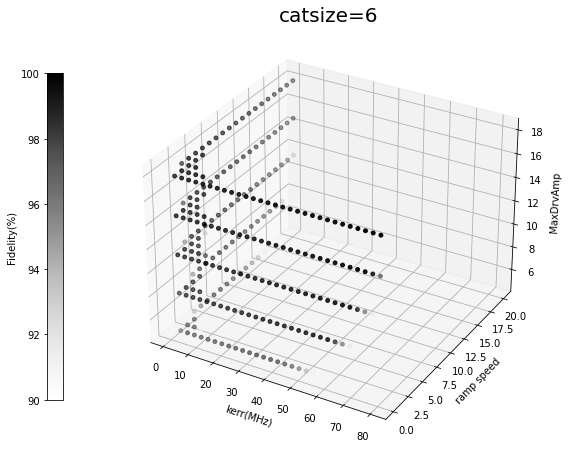

In [72]:
ref2.init_fidelity_exp(spec='test',
kstart=0.75, kstop=80, knum=30,
vstart=0.2, vstop=20, vnum=20)
# 3h 

In [136]:
ref.z

[]

In [137]:
ref=system(chi=20, tau_speed=5, ramp='ad_exp', catsize=4, start=0, stop=2,num=2000)


In [142]:
ref.x

[0.75, 0.75, 0.75, 40.375, 40.375, 40.375, 80.0, 80.0, 80.0]

In [84]:
ref_inst=system(chi=6.7, tau_speed=1.125, ramp='inst', catsize=2.6, start=0, stop=2,num=500)


In [78]:
ref_tanh=system(chi=6.7, tau_speed=1.125, ramp='ad_tanh', catsize=2.6, start=0, stop=2,num=500)


In [82]:
ref_lin=system(chi=6.7, tau_speed=1.125, ramp='lin', catsize=2.6, start=0, stop=2,num=500)


In [70]:
det=system(chi=6.7, tau_speed=1.125, ramp='lin', catsize=2.6, start=0, stop=2,num=500)


In [85]:
ref_inst.generate(H='x',spec='ref_inst_1.125',speed=20)

(0.38436203474328706, 0.012)

In [ ]:
ref_tanh.generate(H='x',spec='ref_tanh_1.125',speed=20)

(0.5327329343455133, 0.02)

In [71]:
det.generate(H='x,det',spec='det_1.125',speed=20)

(0.9897998443749221, 1.972)

In [83]:
ref_lin.generate(H='x',spec='ref_lin_1.125',speed=20)

(0.8269649870030051, 0.032)

In [28]:
sys.generate(H='x,det',spec='ref_Hx,det',speed=20)

(0.9994474023327627, 1.932)

In [18]:
det=system(chi=0.75, tau_speed=2, ramp='lin', catsize=4, start=0, stop=2,num=500)


In [19]:
det.generate(H='adiabatic',spec='wo_d',speed=20)

(0.9099304777219263, 0.252)

In [20]:
det.generate(H='drv+det',spec='w_d',speed=20)

(0.9671376285120935, 1.944)

In [11]:
sys2=system(chi=0.75, tau_speed=1, ramp='ad_exp', catsize=4, start=0.01, stop=2,num=500)


In [12]:
sys2.generate(H='nonadiabatic',spec='x,y',speed=20)

C:\Users\kimje\AppData\Local\Temp\ipykernel_25880\1229571872.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  alpha_prime=sqrt(0.5*(1/sqrt(self.catsize*(1-exp((-(t)**4)/(self.tau**4)))))*((-1)*self.catsize*exp((-(t)**4)/(self.tau**4)))*((-4)*(t**3)/(self.tau**4)))
C:\Users\kimje\AppData\Local\Temp\ipykernel_25880\1229571872.py:47: RuntimeWarning: invalid value encountered in double_scalars
  alpha_prime=sqrt(0.5*(1/sqrt(self.catsize*(1-exp((-(t)**4)/(self.tau**4)))))*((-1)*self.catsize*exp((-(t)**4)/(self.tau**4)))*((-4)*(t**3)/(self.tau**4)))


(0.7730910708615085, 0.25472)

In [4]:
sys2=system(chi=0.75, tau_speed=1, ramp='ad_exp', ham='x,y', catsize=4, start=0, stop=2,num=500)


In [ ]:
sys2.generate(spec='2',speed=20)

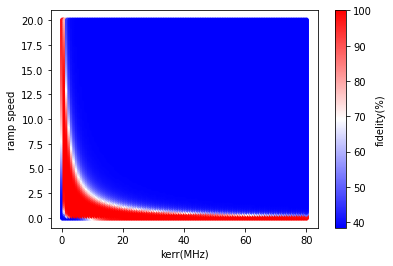

In [69]:
sys.init_fidelity(0.35, 80, 100, 0.01, 20, 100)

In [109]:
linspace(0.01,20,100)

array([1.00000000e-02, 2.11919192e-01, 4.13838384e-01, 6.15757576e-01,
       8.17676768e-01, 1.01959596e+00, 1.22151515e+00, 1.42343434e+00,
       1.62535354e+00, 1.82727273e+00, 2.02919192e+00, 2.23111111e+00,
       2.43303030e+00, 2.63494949e+00, 2.83686869e+00, 3.03878788e+00,
       3.24070707e+00, 3.44262626e+00, 3.64454545e+00, 3.84646465e+00,
       4.04838384e+00, 4.25030303e+00, 4.45222222e+00, 4.65414141e+00,
       4.85606061e+00, 5.05797980e+00, 5.25989899e+00, 5.46181818e+00,
       5.66373737e+00, 5.86565657e+00, 6.06757576e+00, 6.26949495e+00,
       6.47141414e+00, 6.67333333e+00, 6.87525253e+00, 7.07717172e+00,
       7.27909091e+00, 7.48101010e+00, 7.68292929e+00, 7.88484848e+00,
       8.08676768e+00, 8.28868687e+00, 8.49060606e+00, 8.69252525e+00,
       8.89444444e+00, 9.09636364e+00, 9.29828283e+00, 9.50020202e+00,
       9.70212121e+00, 9.90404040e+00, 1.01059596e+01, 1.03078788e+01,
       1.05097980e+01, 1.07117172e+01, 1.09136364e+01, 1.11155556e+01,
      

In [108]:
linspace(0.35,80,100)

array([ 0.35      ,  1.15454545,  1.95909091,  2.76363636,  3.56818182,
        4.37272727,  5.17727273,  5.98181818,  6.78636364,  7.59090909,
        8.39545455,  9.2       , 10.00454545, 10.80909091, 11.61363636,
       12.41818182, 13.22272727, 14.02727273, 14.83181818, 15.63636364,
       16.44090909, 17.24545455, 18.05      , 18.85454545, 19.65909091,
       20.46363636, 21.26818182, 22.07272727, 22.87727273, 23.68181818,
       24.48636364, 25.29090909, 26.09545455, 26.9       , 27.70454545,
       28.50909091, 29.31363636, 30.11818182, 30.92272727, 31.72727273,
       32.53181818, 33.33636364, 34.14090909, 34.94545455, 35.75      ,
       36.55454545, 37.35909091, 38.16363636, 38.96818182, 39.77272727,
       40.57727273, 41.38181818, 42.18636364, 42.99090909, 43.79545455,
       44.6       , 45.40454545, 46.20909091, 47.01363636, 47.81818182,
       48.62272727, 49.42727273, 50.23181818, 51.03636364, 51.84090909,
       52.64545455, 53.45      , 54.25454545, 55.05909091, 55.86

In [104]:
sys.x_chi

[0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 0.35,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545454545,
 1.1545454545

In [105]:
sys.y_v

[14.144343434343433,
 14.346262626262625,
 14.548181818181817,
 14.750101010101009,
 14.9520202020202,
 15.153939393939394,
 15.355858585858586,
 15.557777777777778,
 15.75969696969697,
 15.961616161616162,
 16.163535353535355,
 16.365454545454547,
 16.56737373737374,
 16.76929292929293,
 16.971212121212123,
 17.173131313131314,
 17.375050505050506,
 17.576969696969698,
 17.77888888888889,
 17.98080808080808,
 18.182727272727274,
 18.384646464646465,
 18.586565656565657,
 18.78848484848485,
 18.99040404040404,
 19.192323232323233,
 19.394242424242425,
 19.596161616161616,
 19.798080808080808,
 20.0,
 1.4234343434343435,
 1.6253535353535353,
 1.8272727272727272,
 2.029191919191919,
 2.231111111111111,
 2.4330303030303027,
 2.6349494949494945,
 2.8368686868686868,
 3.0387878787878786,
 3.2407070707070704,
 3.4426262626262623,
 3.644545454545454,
 3.8464646464646464,
 4.048383838383838,
 4.25030303030303,
 4.452222222222222,
 4.654141414141414,
 4.8560606060606055,
 5.057979797979797,
 5.

In [94]:
x=sys.x_chi
y=sys.y_v
c=sys.fidelity
a=[]
b=[]
for k in x:
    for v in y:
        a.append(k)
        b.append(v)
for i in range(len(c)):
    if c[i]<90:
        del a[i]
        del b[i]
        del c[i]
    elif c[i]>=90:
        pass
plt.scatter(a,b,c=c, s=20, cmap=plt.cm.Reds, alpha=1)
plt.xlabel('kerr(MHz)')
plt.ylabel('ramp speed')
plt.colorbar(label='fidelity(%)')
name=f"fidelity90,n=2.6,k=(0.35,80,100),v=(0.01,20,100)"
file_name=f"C:/Users/kimje/Desktop/Project/Posco/Cat/data/fidelity/230212/{name}.png"
plt.savefig(file_name, format='png', dpi=100, bbox_inches='tight')
plt.show()
        

IndexError: list index out of range

In [ ]:
sys.generate(H='adiabatic', spec='ad_exp', speed=20)

(0.998500370278381, 1.3800000000000001)

In [65]:
sys_lin=system(chi=0.75, tau_speed=5, ramp='lin', catsize=4, start=0, stop=2,num=500)


In [66]:
sys.generate(H='adiabatic', spec='ad_exp', speed=20)

(0.998500370278381, 1.3800000000000001)

In [64]:
sys.generate(H='drv+det', spec='ad_exp,ad_det', speed=20)

(0.9994474023327627, 1.932)

In [67]:
sys_lin.generate(H='drv+det', spec='ad_lin,ad_det', speed=20)

(0.9955463654702429, 0.9480000000000001)

[0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 9.555555555555555, 9.555555555555555, 18.36111111111111, 27.166666666666664, 35.97222222222222, 44.77777777777778, 53.58333333333333, 62.388888888888886, 71.19444444444444, 80.0]
[2.231111111111111, 4.452222222222222, 6.673333333333333, 8.894444444444444, 11.115555555555554, 13.336666666666666, 15.557777777777778, 17.77888888888889, 20.0, 0.01, 2.231111111111111, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
[82.3607, 94.7612, 99.0027, 99.8528, 99.9824, 100.0055, 100.0094, 99.9929, 99.6363, 68.7723, 80.4065, 97.9598, 100.0039, 100.011, 100.011, 100.011, 100.011, 100.011, 100.011]


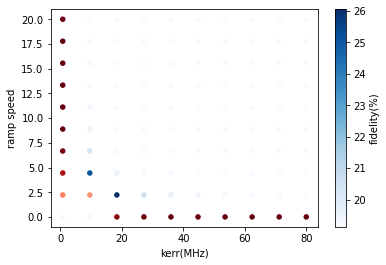

In [49]:
sys.init_fidelity(0.75, 80, 10, 0.01, 20, 10)

In [46]:
sys.init_fidelity(0.35, 80, 100, 0.01, 20, 100)

KeyboardInterrupt: 

[0.75, 0.75, 0.75]
[5.0, 7.5, 10.0]
[96.8406, 99.5558, 99.9414]


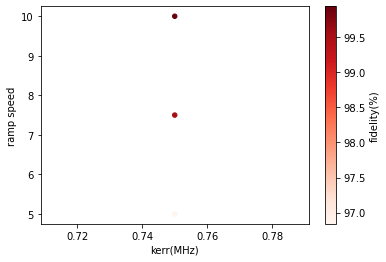

In [ ]:
sys.init_fidelity(0.75, 80, 3, 5, 10, 3)

[0.75, 0.75, 0.75, 40.375, 40.375, 40.375, 80.0, 80.0, 80.0]
[5.0, 7.5, 10.0, 5.0, 7.5, 10.0, 5.0, 7.5, 10.0]
[96.8406, 99.5558, 99.9414, 19.1488, 19.1395, 19.1379, 19.138, 19.1374, 19.1373]


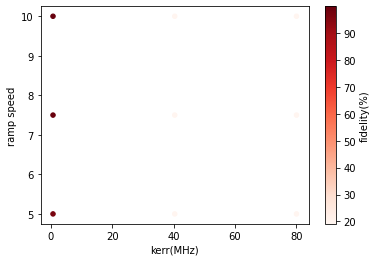

In [ ]:
sys.init_fidelity(0.75, 80, 3, 5, 10, 3)

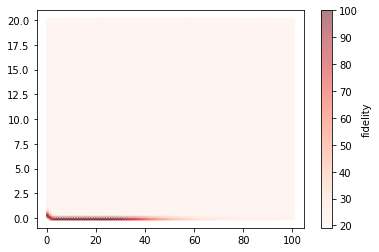

In [26]:
sys.init_fidelity() #10000 pt 275min

In [10]:
sys.generate('adiabatic','K',  20)

(0.9985003605227244, 1.3800000000000001)

In [32]:
sys=system(-0.75, 5, 'ad_exp', 4)

In [33]:
sys.generate('adiabatic','K', 0, 2, 500, 20)

(0.9985003634474527, 1.3800000000000001)

In [34]:
sys=system(-0.075, 5, 'ad_exp', 4)

In [35]:
sys.generate('adiabatic','0.1K', 0, 18, 500, 20)

(0.9985142334532595, 13.787999999999998)

In [36]:
sys=system(75, 5, 'ad_exp', 4)

In [37]:
sys.generate('adiabatic','100K', 0, 0.1, 500, 20)

(0.9982953398900526, 0.014)